In [31]:
import matplotlib.pyplot as plt
import numpy as np
from amuse.units import units
import matplotlib.ticker

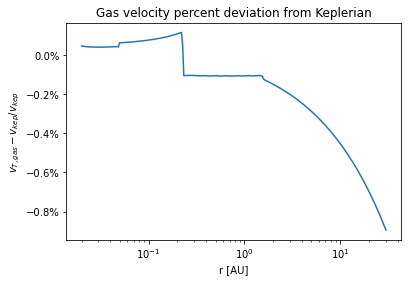

In [39]:
r, vt_gas_cms = np.loadtxt("mdot9disk20220601/vt_gas.txt").T
vt_gas = (vt_gas_cms | units.cm / units.s).value_in(units.au / units.yr)
keplerian = (r ** (-1.0/2) * 2 * np.pi)

fig, ax = plt.subplots()
ax.plot(r, 100*(vt_gas - keplerian)/keplerian)

ax.set_xscale("log")
ax.set_xlabel("r [AU]")

ax.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=1))
ax.set_ylabel("$v_{T,gas}-v_{kep} / v_{kep}$")
ax.set_title("Gas velocity percent deviation from Keplerian")

plt.savefig("vt_gas_keplerian_deviation.png", facecolor="white")
plt.show()

In [15]:
r, vr_gas_cms = np.loadtxt("mdot9disk20220601/rt_gas.txt").T
vr_gas = (vt_gas_cms | units.cm / units.s).value_in(units.au / units.yr)
keplerian = (r ** (-1.0/2) * 2 * np.pi)
plt.plot(r, 100*(vt_gas - keplerian)/keplerian)
plt.xscale("log")
plt.xlabel("r [AU]")

plt.gca().yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(decimals=1))
plt.ylabel("$v_{T,gas}-v_{kep} / v_{kep}$")

plt.title("Gas velocity percent deviation from Keplerian")

quantity<[44.4489004259, 43.8184912303, 43.1966464025, 42.5834292261, 41.9792404966, 41.3838270799, 40.7966827081, 40.2179550427, 39.647454233, 39.0850537122, 38.5306480077, 37.9841527414, 37.4453991575, 36.9143028778, 36.3907584298, 35.8746603411, 35.3658820447, 34.8642758789, 34.3698418439, 33.8825166561, 33.402026087, 32.9283701365, 32.4614433323, 32.0011402017, 31.5472497997, 31.1000252604, 30.6590446938, 30.2242026272, 29.7958154783, 29.373208223, 28.9569082238, 28.5455232436, 28.1467738701, 27.7476026067, 27.3541901422, 26.9663466264, 26.5840087756, 26.2070922119, 25.8355336516, 25.469248717, 25.1081530298, 24.7521833066, 24.401276264, 24.0553475238, 23.7143127082, 23.378129628, 23.0467139053, 22.7199811621, 22.3979103038, 22.080395858, 21.7673956357, 21.4588252588, 21.1546636328, 20.8547989569, 20.5591911516, 20.2677790427, 19.9805035657, 19.6973056559, 19.4181283582, 19.1429126081, 18.8715993408, 18.6041400391, 18.3404798572, 18.0805618399, 17.8243353606, 17.5717434639, 17.3227

In [258]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Create velocity.txt and density.txt for the data from Xiao

# r = np.linspace(0.05, 0.50, 1000)
r = np.loadtxt("mdot9disk20220601/rad_chart.txt")

def load_data(name):
    _r, _l = np.loadtxt(f"mdot9disk20220601/{name}.txt").T
    # return interp1d(_r, _l, kind="quadratic")(r)
    return _l

# Merge velocity files
vt_gas = load_data("vt_gas")
vr_gas = load_data("vr_gas")

velocity = np.column_stack([r, vt_gas, vr_gas])
# np.savetxt("velocity.txt", velocity, fmt="%.6e")

# Calculate density
T = load_data("temperature")
k_B = 1.3807e-16 # cm^2 g s^-2 K^-1
m_p = 1.66e-24; mu = 2.33; gamma = 1.4
c_s = np.sqrt(gamma * k_B * T / (mu * m_p)) # cm s^-1

r_cm = r * 14959787069100
Ω = 2 * np.pi * (r ** (-3.0 / 2)) / (31558150) # s^-1
H = c_s / Ω
v_K = r_cm * Ω
# np.savetxt("scale_height_2.txt", np.column_stack([r, H]), fmt="%.6e")

rho_p = 3
v = v_K - vt_gas
va = np.abs(v)
vs = np.sign(v)

sigma = load_data("sigma")
rho_0 = sigma / (H * np.sqrt(2*np.pi))
# np.savetxt("midplane_density_2.txt", np.column_stack([r, rho_0]), fmt="%.6e")

alpha = load_data("alpha")
nu = alpha * c_s * H
eta = nu * rho_0

l = np.logical_and(r > 0.15, r < 0.35)
Re_a = 2 * va * rho_0 / eta

lM = np.linspace(-3, 0, 100)
M = np.power(10., lM)
a = (M * 5.97e27 * 3 / (rho_p * 4 * np.pi))**(1. / 3)
Re = Re_a[:, np.newaxis] * a[np.newaxis, :]

t_fric = np.zeros_like(Re)
n = Re > 1.
t_fric[n] = ((2**(.6) * rho_p * a[np.newaxis, :]**1.6) / (9 * (eta**.6 * rho_0**.4 * va**.4)[:, np.newaxis]))[n]
n = np.logical_not(n)
t_fric[n] = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))[n]

# t_fric = ((2 * rho_p * a[np.newaxis, :]**2.) / (9 * (eta)[:, np.newaxis]))

tau = t_fric * Ω[:, np.newaxis]

_eta = 1 - np.sqrt(vt_gas / v_K)
v_rp = (-_eta * v_K)[:, np.newaxis] / (tau + 1. / tau)

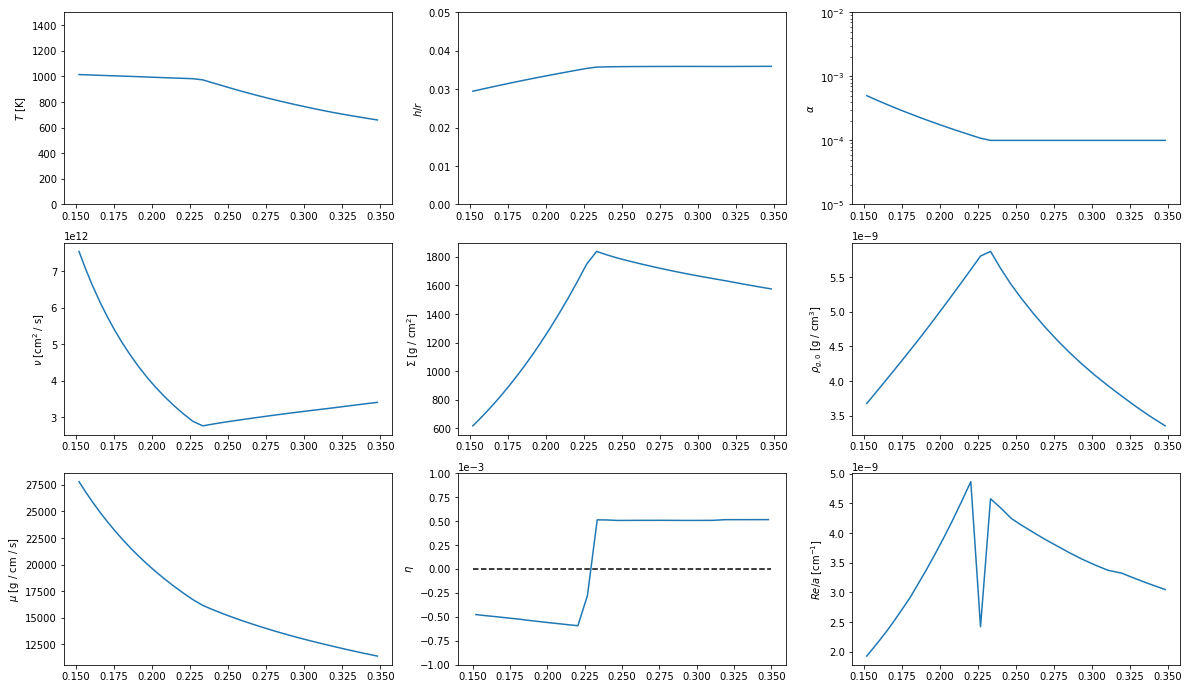

In [259]:

fig, _axs = plt.subplots(3, 3, figsize=(20, 12))
axs = np.ravel(_axs)

axs[0].plot(r[l], T[l])
axs[0].set_ylim(0, 1500)
axs[0].set_ylabel("$T$ [K]")

axs[1].plot(r[l], (H/r_cm)[l])
axs[1].set_ylim(0, 0.05)
axs[1].set_ylabel("$h/r$")

axs[2].plot(r[l], alpha[l])
axs[2].set_yscale("log")
axs[2].set_ylim(1e-5, 1e-2)
axs[2].set_ylabel("$\\alpha$")

axs[3].plot(r[l], nu[l])
axs[3].set_ylabel("$\\nu$ [cm$^2$ / s]")

axs[4].plot(r[l], sigma[l])
axs[4].set_ylabel("$\\Sigma$ [g / cm$^2$]")

axs[5].plot(r[l], rho_0[l])
axs[5].set_ylabel("$\\rho_{g,0}$ [g / cm$^3$]")

axs[6].plot(r[l], eta[l])
axs[6].set_ylabel("$\\mu$ [g / cm / s]")

axs[7].hlines(0, 0.15, 0.35, linestyles="--", color="black")
axs[7].plot(r[l], _eta[l])
axs[7].set_ylim(-0.001, 0.001)
axs[7].set_ylabel("$\\eta$")
axs[7].ticklabel_format(axis="y", style="sci", scilimits=(-1,1))

axs[8].plot(r[l], Re_a[l])
axs[8].set_ylabel("$Re / a$ [cm$^{-1}$]")

plt.savefig("disk.png")

In [260]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

def contourf_blocked(x, **kwargs):
    x_k = x.copy()
    x_k[j] = np.nan
    x_j = x.copy()
    x_j[k] = np.nan

    plt.contourf(r[l], lM, x_j[l].T, **kwargs)
    plt.contourf(r[l], lM, x_k[l].T, **kwargs)

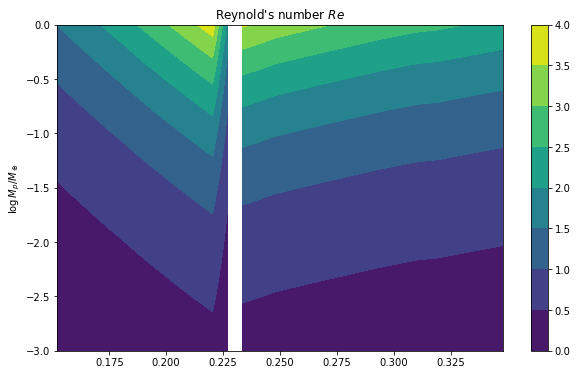

In [261]:
plt.figure(figsize=(10, 6))
contourf_blocked(Re)
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Reynold's number $Re$")
plt.colorbar()
plt.savefig("Re.png")

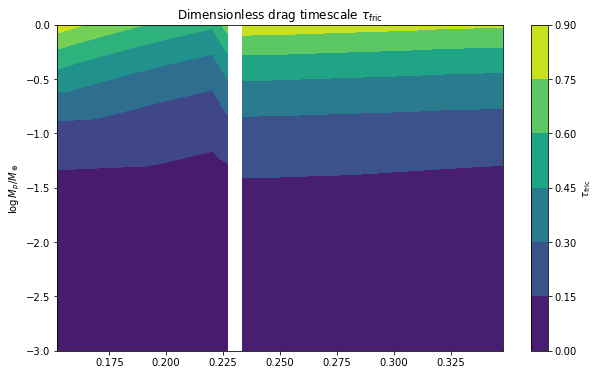

In [262]:
plt.figure(figsize=(10, 6))
contourf_blocked(tau / 31558150)
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Dimensionless drag timescale $\\tau_{\\rm fric}$")
plt.colorbar(label="$\\tau_{\\rm fric}$")

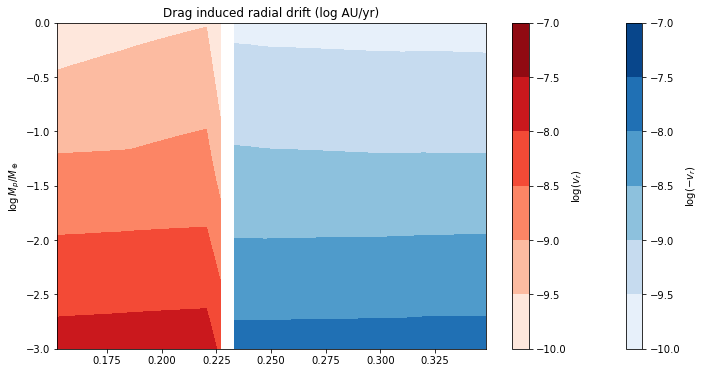

In [263]:
k = np.logical_and(l[:, np.newaxis], v_rp < 0.)
j = np.logical_not(k)

v_rp_k = v_rp.copy()
v_rp_k[k] = np.nan

v_rp_j = v_rp.copy()
v_rp_j[j] = np.nan

plt.figure(figsize=(12, 6))
a = plt.contourf(r[l], lM, np.log10((v_rp_k[l]).T * 2.109532e-6), np.arange(-10, -6.9, 0.5), cmap="Reds")
b = plt.contourf(r[l], lM, np.log10((-v_rp_j[l]).T * 2.109532e-6), np.arange(-10, -6.9, 0.5), cmap="Blues")
plt.ylabel("$\\log M_p / M_\oplus$")
plt.title("Drag induced radial drift (log AU/yr)")
plt.colorbar(b, label="$\\log(-v_r)$")
plt.colorbar(a, label="$\\log(v_r)$")